# AMAL - TP 1 - Définition de fonctions en pyTorch

In [1]:
import numpy as np
import torch
from torch.autograd import Function
from torch.autograd import gradcheck
from datamaestro import prepare_dataset 
from torch.utils.tensorboard import SummaryWriter
import time

/home/pmarion/anaconda3/envs/pytorch/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pmarion/anaconda3/envs/pytorch/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pmarion/anaconda3/envs/pytorch/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pmarion/anaco

## Implémentation & test des classes Pytorch 

In [2]:
class Context:
    """Very simplified context object"""
    def __init__(self):
        self._saved_tensors = ()
    def save_for_backward(self, *args):
        self._saved_tensors = args
    @property
    def saved_tensors(self):
        return self._saved_tensors

On commence par implémenter le cas unidimensionnel avant d'implémenter le cas multi-dimensionnel. Pour chaque classe, on la teste juste après sa définition.

In [3]:
class Linear1(Function):
    """Implementation of f(x, w, b) = <x, w> + b"""
    @staticmethod
    def forward(ctx,x, w, b):
        ## Calcul la sortie du module
        ctx.save_for_backward(x,w)
        return torch.dot(x, w) + b

    @staticmethod
    def backward(ctx, grad_output):
        ## Calcul du gradient du module par rapport a chaque groupe d'entrées
        x,w = ctx.saved_tensors
        return grad_output * w , grad_output * x, grad_output

In [4]:
def test_linear1():
    ## test de la fonction
    estimator = Linear1()
    ctx_estimator = Context()
    x = torch.randn(5,requires_grad=True,dtype=torch.float64)
    w = torch.randn(5,requires_grad=True,dtype=torch.float64)
    b = torch.randn(1,requires_grad=True,dtype=torch.float64)
    output = estimator.forward(ctx_estimator,x,w, b)

    estimator_grad = estimator.backward(ctx_estimator,1)

    ## Pour tester le gradient 
    estimator_check = Linear1.apply
    return torch.autograd.gradcheck(estimator_check,(x,w, b))

test_linear1()

True

In [5]:
class LinearBatch(Function):
    """Implementation of f(X, w, b) = X.dot(w) + b"""
    @staticmethod
    def forward(ctx, X, w, b):
        ## Calcul la sortie du module
        ctx.save_for_backward(X,w)
        return torch.mm(X, torch.transpose(w, 0, 1)) + b

    @staticmethod
    def backward(ctx, grad_output):
        ## Calcul du gradient du module par rapport a chaque groupe d'entrées
        X, w = ctx.saved_tensors
        return torch.mm(grad_output, w) , torch.mm(torch.transpose(grad_output, 0, 1), X), torch.sum(grad_output, 0)

In [6]:
b_size = 10
def test_linearBatch():
    ## Test de la fonction 
    estimator = LinearBatch()
    ctx_estimator = Context()
    x = torch.randn(b_size, 5,requires_grad=True,dtype=torch.float64)
    w = torch.randn(1, 5,requires_grad=True,dtype=torch.float64)
    b = torch.randn(1,requires_grad=True,dtype=torch.float64)
    output = estimator.forward(ctx_estimator,x,w, b)

    grad_output = torch.randn(b_size, 1,requires_grad=True,dtype=torch.float64)
    estimator_grad = estimator.backward(ctx_estimator, grad_output)

    ## Pour tester le gradient 
    estimator_check = LinearBatch.apply
    return torch.autograd.gradcheck(estimator_check,(x,w, b))

test_linearBatch()

True

In [7]:
class MSE(Function):
    """Implementation of f(yhat, y) = ||yhat-y||^2"""
    @staticmethod
    def forward(ctx, yhat, y):
        ## Calcul la sortie du module
        ctx.save_for_backward(yhat,y)
        return torch.norm(yhat-y, p=2)**2 / len(y)

    @staticmethod
    def backward(ctx, grad_output):
        ## Calcul du gradient du module par rapport a chaque groupe d'entrées
        yhat,y = ctx.saved_tensors
        return 2 * grad_output * (yhat-y) / len(y) ,  -2 * grad_output * (yhat-y) / len(y)

In [8]:
class MSE2(Function):
    """Implementation of f(yhat, y) = ||yhat-y||^2"""
    @staticmethod
    def forward(ctx, yhat, y):
        ## Calcul la sortie du module
        ctx.save_for_backward(yhat,y)
        return torch.norm(yhat-y, p=2)**2 

    @staticmethod
    def backward(ctx, grad_output):
        ## Calcul du gradient du module par rapport a chaque groupe d'entrées
        yhat,y = ctx.saved_tensors
        return 2 * grad_output * (yhat-y) ,  -2 * grad_output * (yhat-y)

In [9]:
def test_MSE():
    mse = MSE()
    ctx_mse = Context()
    y = torch.randn(2,requires_grad=True,dtype=torch.float64)
    yhat = torch.randn(2,requires_grad=True,dtype=torch.float64)
    output = mse.forward(ctx_mse,yhat,y)
    mse_grad = mse.backward(ctx_mse,1)
    ## Pour tester le gradient 
    mse_check = mse.apply
    return torch.autograd.gradcheck(mse_check,(yhat, y))

test_MSE()

True

## Implémentation de l'algorithme de descente de gradient

La fonction `run_gradient_descent` permet d'implémenter les trois variantes de descente de gradient :
+ Gradient batch: `n_batch` = 1
+ Gradient stochastique: `n_batch` = N où N est le nombre de lignes de données
+ Gradient mini-batch: 1 < `n_batch` < N

In [10]:
def run_gradient_descent(data, nb_iteration, n_batch, writer=False):
    
    N = data.shape[0]   # nombre de données
    n_attribute = data.shape[1]-1
    
    if writer:
        writer = SummaryWriter(log_dir='runs/nb_batch=' + str(n_batch) + 'nb_pass=' + str(nb_iteration/n_batch) + '_timestamp=' + str(int(time.time())))
        
    # Initialisation aléatoire des paramètres w et b
    w = torch.randn(1, n_attribute,requires_grad=True,dtype=torch.float64)
    b = torch.randn(1,requires_grad=True,dtype=torch.float64)
    
    eps = 0.05 # Pas de la descente de gradient
    
    estimator = LinearBatch()
    ctx_estimator = Context()
    mse = MSE()
    ctx_mse = Context()

    L_train = 0     # perte pour la partie train
    for k in range(nb_iteration):        
        # Choix des lignes des données qui servent pour cette itération
        # on apprend sur la première moitié du data set
        if n_batch == N: # stochastic 
            idx = [np.random.randint(0, N/2)]
        else:   # batch or mini-batch
            idx_min = int(N/n_batch * k) % N
            idx_max = int(N/n_batch * (k+1)) % N
            if idx_min < idx_max:
                idx = range(idx_min, idx_max)
            else:
                idx = list(range(idx_min, N)) + list(range(N, idx_max))
            
        X = torch.from_numpy(data[idx, :-1])
        y = torch.from_numpy(data[idx][: , [-1]])
        L_train = (k*L_train + mse.forward(ctx_mse, estimator.forward(ctx_estimator, X, w, b), y)) / (k+1)    # update L_train
        estimator_grad = estimator.backward(ctx_estimator, mse.backward(ctx_mse, 1)[0])
        w = w - eps * estimator_grad[1]
        b = b - eps * estimator_grad[2]
        if k % 10 == 0 and writer:
            # Pour comparer les différente méthodes, on compte le nombre de lignes de données utilisées à chaque itération
            writer.add_scalar('Loss/train', L_train/len(idx), k*len(idx))

    
    L_test = 0  # perte pour la partie test
    for k in range(int(N/2)):     # on teste sur la seconde moitié du data set
        x = torch.from_numpy(data[[int(N/2) + k], :-1])
        y = torch.from_numpy(data[[int(N/2) + k]][: , [-1]])
        L_test = (k*L_test + mse.forward(ctx_mse, estimator.forward(ctx_estimator, x, w, b), y)) / (k+1)
        if writer:
            writer.add_scalar('Loss/test', L_test, k)
    
    print('Test loss: ' + str(L_test.item()))
    if writer:
        writer.close()

## Test avec les données de Boston Housing

In [11]:
## Pour telecharger le dataset Boston
ds=prepare_dataset("edu.uci.boston")
fields, data =ds.files.data() 
N = data.shape[0]

In [12]:
# Pour randomizer les données et diminuer le conditionnement
np.random.shuffle(data)
data = data / data.max(axis=0)

In [13]:
# On compare les trois variantes (batch / stochastic / mini-batch) en utilisant à chaque fois au total `n_pass` fois les données
# Le nombre d'itérations n'est donc pas le même selon les variantes
n_pass = 100
run_gradient_descent(data, n_pass, 1, writer=True)    # batch
run_gradient_descent(data, n_pass*N, N, writer=True)  # stochastic
n_batch = 10
run_gradient_descent(data, n_pass*n_batch, n_batch, writer=True)   # mini-batch

Test loss: 0.0683766443948943
Test loss: 0.02050302767177825
Test loss: 0.027567570856946916


In [14]:
run_gradient_descent(data, n_pass*10, 1, writer=True)    # batch avec 10x plus de pass sur les données

Test loss: 0.019563858587584394


On obtient les courbes suivantes sur Tensorboard:

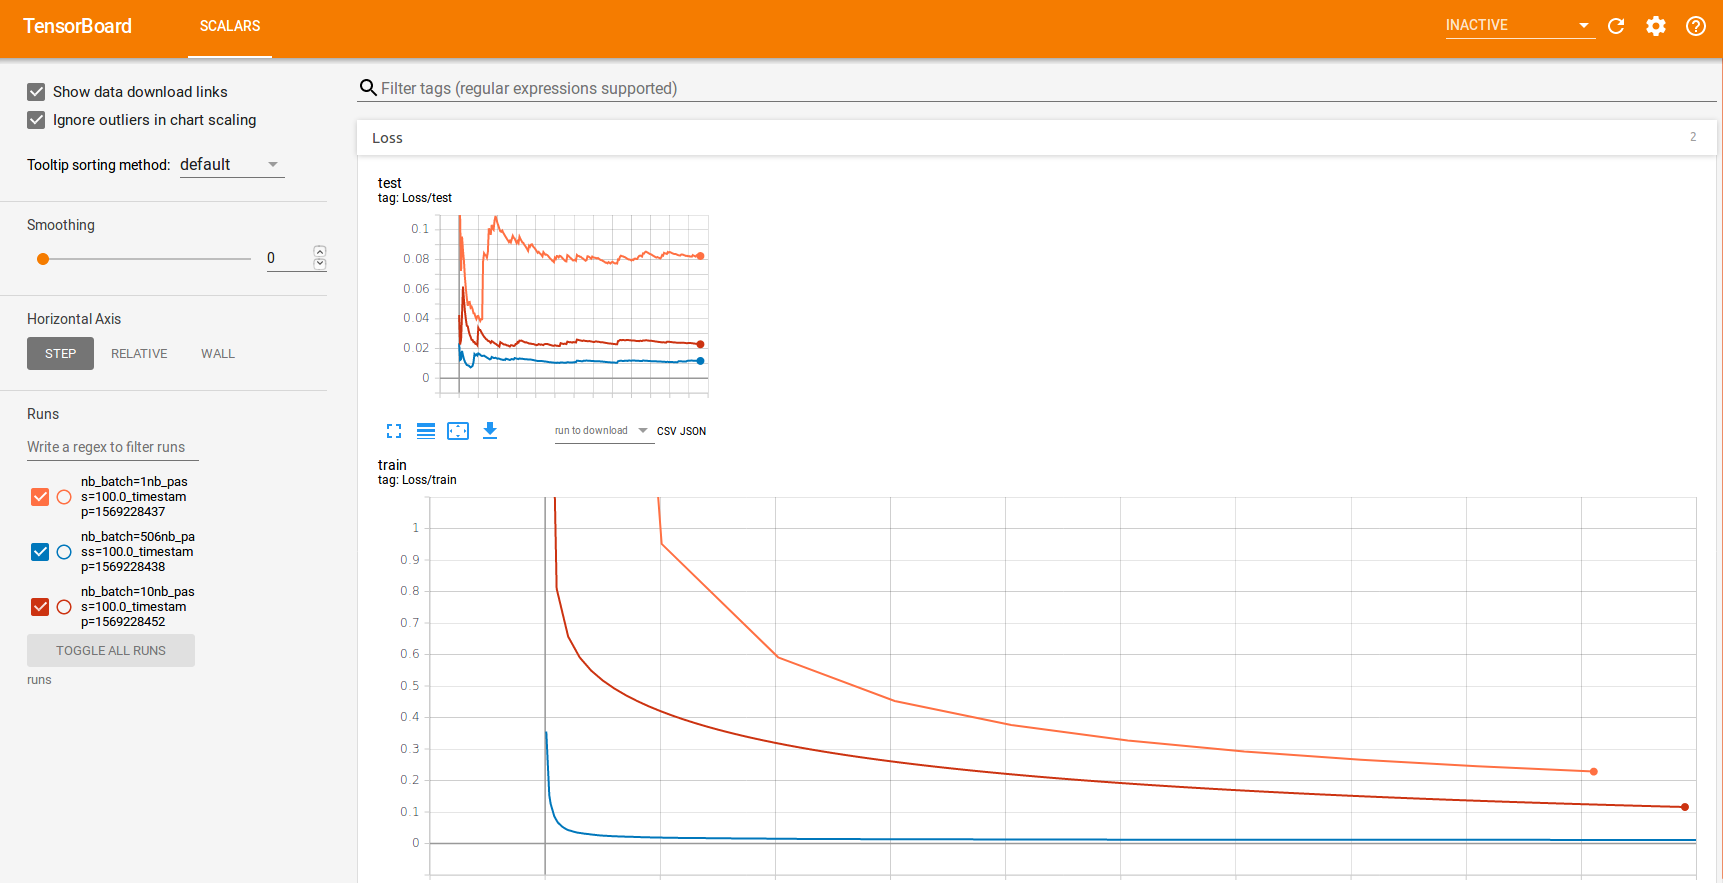

In [15]:
from IPython.display import Image
Image("Screenshot.png", width=800)

On observe plusieurs phénomènes intéressants :
+ à nombre de lectures des données égales, et sur le jeu de test présenté, les variantes stochastique (en bleu) et mini-batch (en rouge) obtiennent des meilleurs scores que la variante batch (orange)
+ les courbes des erreurs d'apprentissage nous apprennent que l'erreur d'apprentissage est extrêmement élevée au début pour les variantes batch et mini-batch. Cela signifie que le pas de la descente de gradient n'est peut-être pas bien réglé dans les cas batch et mini-batch.

Pour faire une comparaison plus pertinente entre les méthodes, il faudrait implémenter une règle pour le pas de la descente de gradient (exact line search ou backtracking line search)